![title](../images/header.png)

CEO data quality assessment
-------
This notebook assessing differences in CEO validation and review

###### For more information contact aurelie.shapiro@fao.org or remi.dannunzio@fao.org

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# Set the display option to a large value to prevent text wrapping
pd.set_option('display.max_colwidth', None)

In [2]:
# read cleaned merged data to evaluate
ceo = pd.read_csv('/home/sepal-user/module_results/esbae/EQG/EQG_all_ceo_2023_clean.csv')

In [3]:
# read CEO output from QC project
ceo_qc = pd.read_csv('/home/sepal-user/module_results/esbae/EQG/ceo-CAFI-DDD-EQG-TNT-2023-CQ-sample-data.csv')

In [4]:
# output file CEO validated data with QC
ceo_qc_data_out =  '/home/sepal-user/module_results/esbae/EQG/EQG_all_ceo_2023_clean_qc.csv'

In [5]:
len(ceo)

753

In [6]:
print(ceo.dtypes)

ID                          int64
plotid                      int64
sampleid                    int64
lon                       float64
lat                       float64
TNT_stratum                 int64
sample_geom                object
Ref_FNF_2022                int64
Ref_Regeneration           object
Ref_Change_2023             int64
Ref_Change_Type_2023       object
ArtFor                      int64
ArtMine                     int64
InfraR                      int64
Urb                         int64
IndFor                      int64
Other                       int64
Other_Desc                float64
IndMine                     int64
IndAg                       int64
ArtAg                       int64
Ref_NFtype_2022           float64
Ref_Ftype_2022            float64
collection                 object
interpreted                 int64
Ref_LCover_2022             int64
Ref_Change_Year_2023       object
Ref_Change_LCover_2023     object
Def2023                     int64
Deg2023       

In [7]:
print(ceo_qc.dtypes)

plotid                                            int64
sampleid                                          int64
sample_internal_id                                int64
lon                                             float64
lat                                             float64
email                                            object
flagged                                            bool
collection_time                                  object
analysis_duration                                object
imagery_title                                    object
imagery_attributions                            float64
sample_geom                                      object
pl_plantation                                     int64
pl_woodland_deg                                   int64
pl_indag                                          int64
pl_sampleid                                       int64
pl_mangrove_deg                                   int64
pl_gallery_stable                               

In [8]:
ceo['Ref_Change_Type_2023'].value_counts()

Ref_Change_Type_2023
Stable    663
NF         78
Deg         6
Def         6
Name: count, dtype: int64

In [9]:
# Step 1: Sort the DataFrame by 'collection_time' in ascending order
ceo_qc.sort_values(by='collection_time', ascending=True, inplace=True)

# Step 2: Remove duplicates keeping the first occurrence (most recent 'plotid')
ceo_qc.drop_duplicates(subset='plotid', keep='first', inplace=True)

# Step 3: Reset the index
ceo_qc.reset_index(drop=True, inplace=True)

# Step 4: Add 'collection' column with the collection counter
ceo_qc['collection'] = "QC 2023"

# Step 5: Add 'interpreted' column: 1 if 'email' is not null, otherwise 0
ceo_qc['interpreted_qc'] = np.where(ceo_qc['email'].notna(), '1', '0')

# Step 6: Specify the columns you want to keep
columns_to_keep = ['plotid', 'sampleid', 'sample_internal_id', 'lon', 'lat', 'sample_geom', 'pl_sampleid', 'pl_plotid_old', 'pl_id',
                   'forêt ou non-forêt en 2022', "Y'a t'il de la régéneration", 
                   'Changement en 2023', 'Type de Changement 2023', 'Exploitation forestière artisanale (<5ha)', 
                   'Activité minière artisanale', 'Infrastructure routière', 'Infrastructure d’urbanisation ou habitations', 
                   'Exploitation forestière industrielle (>5ha)', 'Autre moteur', 'Descriptif autre moteur', 
                   'Activité minière industrielle', 'Agriculture industrielle', 'Agriculture paysanne', 
                   'Type de non-forêt en 2022', 'Type de forêt en 2022', 'pl_collection', 'interpreted_qc']

ceo_qc = ceo_qc[columns_to_keep]

# Step 7: Rename the columns
column_mapping = {
    'forêt ou non-forêt en 2022': 'QC_FNF_2022', 
    "Y'a t'il de la régéneration": 'QC_Regeneration',
    'Changement en 2023': 'QC_Change_2023', 
    'Type de Changement 2023': 'QC_Change_Type_2023', 
    'Exploitation forestière artisanale (<5ha)': 'QC_ArtFor',
    'Activité minière artisanale': 'QC_ArtMine',
    'Infrastructure routière': 'QC_InfraR', 
    'Infrastructure d’urbanisation ou habitations': 'QC_Urb',
    'Exploitation forestière industrielle (>5ha)': 'QC_IndFor', 
    'Autre moteur': 'QC_Other', 
    'Descriptif autre moteur': 'QC_Other_Desc', 
    'Activité minière industrielle': 'QC_IndMine', 
    'Agriculture industrielle': 'QC_IndAg', 
    'Agriculture paysanne': 'QC_ArtAg', 
    'Type de non-forêt en 2022': 'QC_NFtype_2022', 
    'Type de forêt en 2022': 'QC_Ftype_2022'}

ceo_qc_clean = ceo_qc.rename(columns=column_mapping)

# Step 8: Replace values in specific columns based on your mapping
replace_dict = {
    'QC_FNF_2022': {'non-forêt': '0', 'forêt': '1'},
    'QC_Ftype_2022': {'1 - forêt dense': '1', '2 - forêt dense sèche': '2', '3 - forêt secondaire': '3',
                       '4 - forêt claire sèche':'4', '7 - forêt mangrove': '7', '8 - forêt marécageuse': '8',
                       '9 - forêt galérie': '9', '10 - plantation forestière': '10', '11- savane arborée': '11'},
    'QC_NFtype_2022': {'12 - savane arbustive': '12', '13 - savane herbacée': '13', '14 - prairie aquatique': '14',
                        '15 - sol nu végétation éparse': '15', '16 - terres cultivées': '16', '17 - zone baties': '17',
                        '18 - eau': '18'},
    'QC_Change_2023': {'oui': '1', 'non': '0', '': '0'},
    'QC_ArtFor': {'oui': '1', 'non': '0', '': '0'},
    'QC_IndFor': {'oui': '1', 'non': '0', '': '0'},
    'QC_ArtAg': {'oui': '1', 'non': '0', '': '0'},
    'QC_IndAg': {'oui':'1', 'non': '0', '': '0'},
    'QC_ArtMine': {'oui': '1', 'non': '0', '': '0'},
    'QC_IndMine': {'oui': '1', 'non': '0', '': '0'},
    'QC_Urb': {'oui': '1', 'non': '0', '': '0'},
    'QC_InfraR': {'oui': '1', 'non': '0', '': '0'},
    'QC_Other': {'oui': '1', 'non': '0', '': '0'}
}

ceo_qc_clean.replace(replace_dict, inplace=True)
ceo_qc_clean = ceo_qc_clean.infer_objects()


# Step 9: Fill NaN values with 0 for specific columns
columns_to_fill = ['QC_Change_2023', 'QC_ArtAg', 'QC_ArtFor', 'QC_IndFor', 'QC_IndAg', 'QC_ArtMine', 'QC_IndMine', 'QC_Urb', 'QC_InfraR', 'QC_Other']
ceo_qc_clean[columns_to_fill] = ceo_qc_clean[columns_to_fill].fillna('0')
ceo_qc_clean['QC_Change_2023'] = ceo_qc_clean['QC_Change_2023'].astype(int)

In [10]:
print(ceo_qc_clean.dtypes)

plotid                   int64
sampleid                 int64
sample_internal_id       int64
lon                    float64
lat                    float64
sample_geom             object
pl_sampleid              int64
pl_plotid_old            int64
pl_id                    int64
QC_FNF_2022             object
QC_Regeneration         object
QC_Change_2023           int64
QC_Change_Type_2023     object
QC_ArtFor               object
QC_ArtMine              object
QC_InfraR               object
QC_Urb                  object
QC_IndFor               object
QC_Other                object
QC_Other_Desc          float64
QC_IndMine              object
QC_IndAg                object
QC_ArtAg                object
QC_NFtype_2022          object
QC_Ftype_2022           object
pl_collection           object
interpreted_qc          object
dtype: object


In [11]:
ceo_qc_clean.head()

,plotid,sampleid,sample_internal_id,lon,lat,sample_geom,pl_sampleid,pl_plotid_old,pl_id,QC_FNF_2022,QC_Regeneration,QC_Change_2023,QC_Change_Type_2023,QC_ArtFor,QC_ArtMine,QC_InfraR,QC_Urb,QC_IndFor,QC_Other,QC_Other_Desc,QC_IndMine,QC_IndAg,QC_ArtAg,QC_NFtype_2022,QC_Ftype_2022,pl_collection,interpreted_qc
0,1,1,765047138,10.007816,1.067243,POINT(10.00781617 1.067243473),65,65,65,1,NaN,0,NaN,0,0,0,0,0,0,NaN,0,0,0,NaN,1,coll_2023_1,1
1,2,2,765047139,8.761494,3.535994,POINT(8.761493545 3.535993537),122,122,122,1,NaN,0,NaN,0,0,0,0,0,0,NaN,0,0,0,NaN,1,coll_2023_1,1
2,3,3,765047140,10.189545,1.321287,POINT(10.18954535 1.321287036),202,202,170,1,NaN,0,NaN,0,0,0,0,0,0,NaN,0,0,0,NaN,1,coll_2023_1,1
3,5,5,765047142,9.913493,1.682230,POINT(9.913493065 1.682230117),2,2,249,1,NaN,0,NaN,0,0,0,0,0,0,NaN,0,0,0,NaN,1,coll_2023_2,1
4,6,6,765047143,11.303816,1.970859,POINT(11.30381563 1.970858818),312,312,569,1,NaN,0,NaN,0,0,0,0,0,0,NaN,0,0,0,NaN,9,coll_2023_2,1


##### clean up QC data

In [12]:
ceo_qc_clean['QC_NFtype_2022'].value_counts(dropna=False)

QC_NFtype_2022
NaN    71
17      3
15      1
Name: count, dtype: int64

In [13]:
ceo_qc_clean['QC_Ftype_2022'].value_counts(dropna=False)

QC_Ftype_2022
1      64
NaN     4
3       4
9       1
7       1
8       1
Name: count, dtype: int64

In [14]:
ceo_qc_clean['QC_Change_Type_2023'].value_counts(dropna=False)

QC_Change_Type_2023
NaN              73
déforestation     1
dégradation       1
Name: count, dtype: int64

In [15]:
ceo_qc_clean = ceo_qc_clean.copy()
ceo_qc_clean.loc[:, 'QC_LCover_2022'] = ceo_qc_clean['QC_Ftype_2022'].fillna(ceo_qc_clean['QC_NFtype_2022'])
ceo_qc_clean['QC_LCover_2022'] = ceo_qc_clean['QC_LCover_2022'].astype(int)
ceo_qc_clean['QC_LCover_2022'].value_counts(dropna=False)

QC_LCover_2022
1     64
3      4
17     3
15     1
9      1
7      1
8      1
Name: count, dtype: int64

In [16]:
# Confirm the column is now of integet type
print(ceo_qc_clean['QC_LCover_2022'].dtype)

int64


In [17]:
def f(x):
  if x['QC_FNF_2022'] == '0' : return 'NF'
  elif x['QC_Change_Type_2023'] == 'déforestation': return 'Def'
  elif x['QC_Change_Type_2023'] == 'dégradation' : return 'Deg'
  else: return 'Stable'

ceo_qc_clean.loc[:, 'QC_Change_Type_2023'] = ceo_qc_clean.apply(f, axis=1)
ceo_qc_clean['QC_Change_Type_2023'].value_counts()

QC_Change_Type_2023
Stable    69
NF         4
Def        1
Deg        1
Name: count, dtype: int64

In [18]:
def y(x):
  if x['QC_Change_Type_2023'] == 'Def': return 'Def2023'
  elif x['QC_Change_Type_2023'] == 'Deg' : return 'Deg2023'
  elif x['QC_Change_Type_2023'] == 'NF' : return 'NF'
  elif x['QC_Change_Type_2023'] == 'Stable' : return 'Stable'
  else: return ''

ceo_qc_clean.loc[:,'QC_Change_Year_2023'] = ceo_qc_clean.apply(y, axis=1)

change_counts = ceo_qc_clean['QC_Change_Year_2023'].value_counts()
change_counts = change_counts.sort_index()
print(change_counts)

QC_Change_Year_2023
Def2023     1
Deg2023     1
NF          4
Stable     69
Name: count, dtype: int64


In [19]:
# Define the new column based on conditions
ceo_qc_clean.loc[:,'QC_Change_LCover_2023'] = ceo_qc_clean.apply(lambda row: f"{row['QC_Change_Type_2023']}_{row['QC_LCover_2022']}", axis=1)
ceo_qc_clean['QC_Change_LCover_2023'].value_counts()

QC_Change_LCover_2023
Stable_1    63
NF_17        3
Stable_3     3
NF_15        1
Stable_9     1
Stable_7     1
Stable_8     1
Def_1        1
Deg_3        1
Name: count, dtype: int64

##### merge CEO and QC data

In [20]:
# Merge ceo_qc_clean and ceo on 'lon' and 'lat' columns
merged_ceo_qc = pd.merge(ceo_qc_clean, ceo, how='inner', on=['sample_geom'], suffixes=('_qc_clean', '_ceo'))

# Display the merged dataframe
merged_ceo_qc.head()

,plotid_qc_clean,sampleid_qc_clean,sample_internal_id,lon_qc_clean,lat_qc_clean,sample_geom,pl_sampleid,pl_plotid_old,pl_id,QC_FNF_2022,QC_Regeneration,QC_Change_2023,QC_Change_Type_2023,QC_ArtFor,QC_ArtMine,QC_InfraR,QC_Urb,QC_IndFor,QC_Other,QC_Other_Desc,QC_IndMine,QC_IndAg,QC_ArtAg,QC_NFtype_2022,QC_Ftype_2022,pl_collection,interpreted_qc,QC_LCover_2022,QC_Change_Year_2023,QC_Change_LCover_2023,ID,plotid_ceo,sampleid_ceo,lon_ceo,lat_ceo,TNT_stratum,Ref_FNF_2022,Ref_Regeneration,Ref_Change_2023,Ref_Change_Type_2023,ArtFor,ArtMine,InfraR,Urb,IndFor,Other,Other_Desc,IndMine,IndAg,ArtAg,Ref_NFtype_2022,Ref_Ftype_2022,collection,interpreted,Ref_LCover_2022,Ref_Change_Year_2023,Ref_Change_LCover_2023,Def2023,Deg2023,Defall,Degall,Stable,NF,DensFor,DensDryFor,SecFor,DryOpenFor,Mangrove,Swamp,Gallery,Plantation,Woodland,Shrubland,Grassland,Aquatic,Bare,Cultivated,Builtup,Water,DensFor_Def,DensDryFor_Def,SecFor_Def,DryOpenFor_Def,Mangrove_Def,Swamp_Def,Gallery_Def,Plantation_Def,Woodland_Def,DensFor_Deg,DensDryFor_Deg,SecFor_Deg,DryOpenFor_Deg,Mangrove_Deg,Swamp_Deg,Gallery_Deg,Plantation_Deg,Woodland_Deg,DensFor_Stable,DensDryFor_Stable,SecFor_Stable,DryOpenFor_Stable,Mangrove_Stable,Swamp_Stable,Gallery_Stable,Plantation_Stable,Woodland_Stable,ISO
0,1,1,765047138,10.007816,1.067243,POINT(10.00781617 1.067243473),65,65,65,1,NaN,0,Stable,0,0,0,0,0,0,NaN,0,0,0,NaN,1,coll_2023_1,1,1,Stable,Stable_1,65,65,65,10.007816,1.067243,1,1,NaN,0,Stable,0,0,0,0,0,0,NaN,0,0,0,NaN,1.0,coll_2023_1,1,1,Stable,Stable_1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,EQG
1,2,2,765047139,8.761494,3.535994,POINT(8.761493545 3.535993537),122,122,122,1,NaN,0,Stable,0,0,0,0,0,0,NaN,0,0,0,NaN,1,coll_2023_1,1,1,Stable,Stable_1,122,122,122,8.761494,3.535994,2,1,NaN,0,Stable,0,0,0,0,0,0,NaN,0,0,0,NaN,1.0,coll_2023_1,1,1,Stable,Stable_1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,EQG
2,3,3,765047140,10.189545,1.321287,POINT(10.18954535 1.321287036),202,202,170,1,NaN,0,Stable,0,0,0,0,0,0,NaN,0,0,0,NaN,1,coll_2023_1,1,1,Stable,Stable_1,170,202,202,10.189545,1.321287,4,1,NaN,0,Stable,0,0,0,0,0,0,NaN,0,0,0,NaN,1.0,coll_2023_1,1,1,Stable,Stable_1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,EQG
3,5,5,765047142,9.913493,1.682230,POINT(9.913493065 1.682230117),2,2,249,1,NaN,0,Stable,0,0,0,0,0,0,NaN,0,0,0,NaN,1,coll_2023_2,1,1,Stable,Stable_1,249,2,2,9.913493,1.682230,1,1,NaN,0,Stable,0,0,0,0,0,0,NaN,0,0,0,NaN,1.0,coll_2023_2,1,1,Stable,Stable_1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,EQG
4,6,6,765047143,11.303816,1.970859,POINT(11.30381563 1.970858818),312,312,569,1,NaN,0,Stable,0,0,0,0,0,0,NaN,0,0,0,NaN,9,coll_2023_2,1,9,Stable,Stable_9,569,312,312,11.303816,1.970859,3,1,NaN,0,Stable,0,0,0,0,0,0,NaN,0,0,0,NaN,1.0,coll_2023_2,1,1,Stable,Stable_1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,EQG


In [21]:
len(merged_ceo_qc)

75

In [22]:
print(merged_ceo_qc.dtypes)

plotid_qc_clean             int64
sampleid_qc_clean           int64
sample_internal_id          int64
lon_qc_clean              float64
lat_qc_clean              float64
sample_geom                object
pl_sampleid                 int64
pl_plotid_old               int64
pl_id                       int64
QC_FNF_2022                object
QC_Regeneration            object
QC_Change_2023              int64
QC_Change_Type_2023        object
QC_ArtFor                  object
QC_ArtMine                 object
QC_InfraR                  object
QC_Urb                     object
QC_IndFor                  object
QC_Other                   object
QC_Other_Desc             float64
QC_IndMine                 object
QC_IndAg                   object
QC_ArtAg                   object
QC_NFtype_2022             object
QC_Ftype_2022              object
pl_collection              object
interpreted_qc             object
QC_LCover_2022              int64
QC_Change_Year_2023        object
QC_Change_LCov

In [23]:
merged_ceo_qc['Ref_FNF_2022'] = merged_ceo_qc['Ref_FNF_2022'].astype(int)
merged_ceo_qc['QC_FNF_2022'] = merged_ceo_qc['QC_FNF_2022'].astype(int)

In [24]:
merged_ceo_qc['QC_LCover_2022'].value_counts(dropna=False)

QC_LCover_2022
1     64
3      4
17     3
15     1
9      1
7      1
8      1
Name: count, dtype: int64

In [95]:
merged_ceo_qc['Ref_Change_2023'].value_counts(dropna=False)

Ref_Change_2023
0    75
Name: count, dtype: int64

In [25]:
merged_ceo_qc['Ref_LCover_2022'].value_counts(dropna=False)

Ref_LCover_2022
1     52
3      8
2      5
15     5
16     2
8      2
7      1
Name: count, dtype: int64

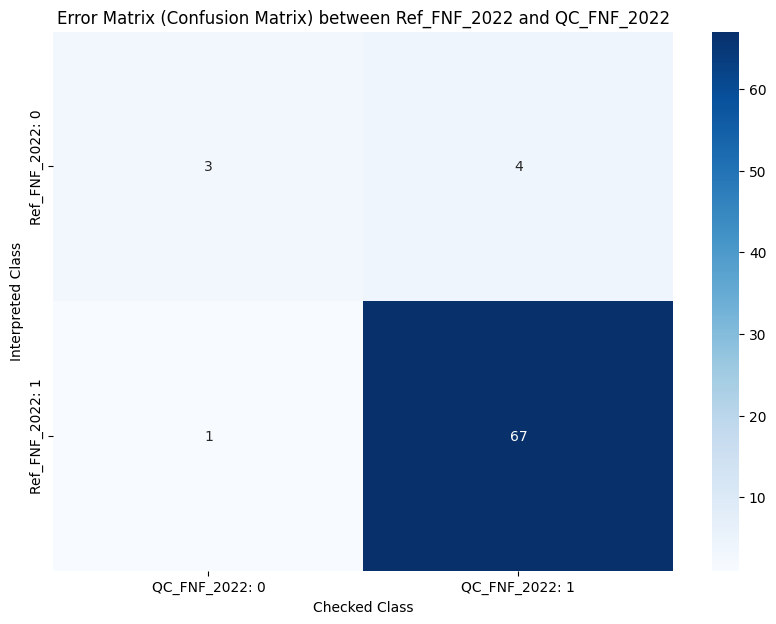

In [96]:
# Step 1: Create the confusion matrix (error matrix)
error_matrix_FNF = confusion_matrix(merged_ceo_qc['Ref_FNF_2022'], merged_ceo_qc['QC_FNF_2022'])
# Step 2: Convert confusion matrix to a DataFrame for better readability
error_matrix_FNF_df = pd.DataFrame(
    error_matrix_FNF, 
    index=['Ref_FNF_2022: ' + str(i) for i in sorted(merged_ceo_qc['Ref_FNF_2022'].unique())], 
    columns=['QC_FNF_2022: ' + str(i) for i in sorted(merged_ceo_qc['QC_FNF_2022'].unique())]
)

# Step 3: Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(error_matrix_FNF_df, annot=True, cmap='Blues', fmt='g', cbar=True)

# Add titles and labels
plt.title('Error Matrix (Confusion Matrix) between Ref_FNF_2022 and QC_FNF_2022')
plt.ylabel('Interpreted Class')
plt.xlabel('Checked Class')

# Show the plot
plt.show()

In [97]:
# Calculate the sum of diagonal elements (correctly classified observations)
correctly_classified_FNF = np.trace(error_matrix_FNF_df)

# Calculate the total number of observations
total_observations_FNF = error_matrix_FNF_df.to_numpy().sum()

# Calculate the percentage agreement
percentage_agreement_FNF = (correctly_classified_FNF / total_observations_FNF) * 100

print(f"General Percentage Agreement: {percentage_agreement_FNF:.2f}%")

General Percentage Agreement: 93.33%


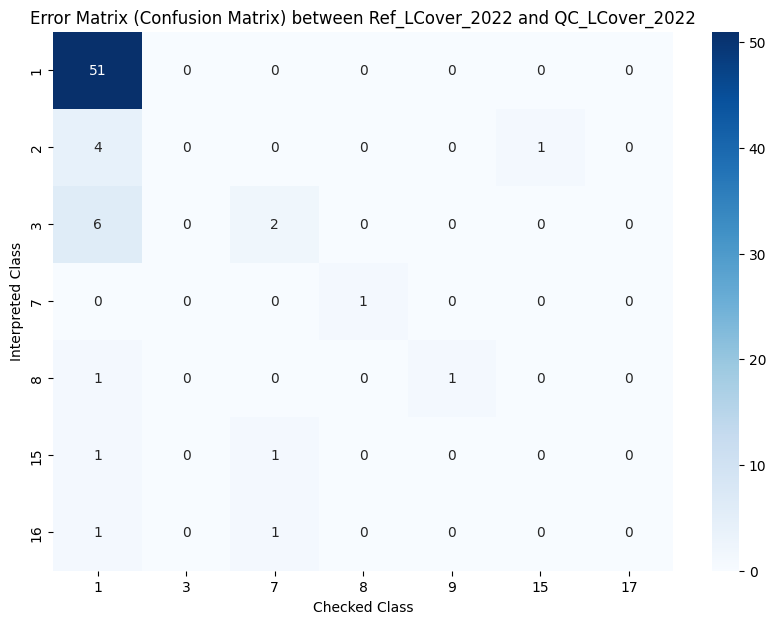

In [98]:
# Assuming merged_ceo_qc is your DataFrame and has the necessary columns
# Example reference and predicted classes
ref_column = 'Ref_LCover_2022'  # Reference class column
qc_column = 'QC_LCover_2022'     # QC class column

# Step 1: Identify unique classes
ref_classes = sorted(merged_ceo_qc[ref_column].unique())
qc_classes = sorted(merged_ceo_qc[qc_column].unique())

# Step 2: Create the confusion matrix
error_matrix_LCover = confusion_matrix(
    merged_ceo_qc[ref_column],
    merged_ceo_qc[qc_column],
    labels=ref_classes  # Ensure all reference classes are included
)

# Step 3: Initialize an empty DataFrame with all combinations of reference and QC classes
error_matrix_LCover_df = pd.DataFrame(0, index=ref_classes, columns=qc_classes)

# Step 4: Fill the DataFrame with the confusion matrix values
for i, ref_class in enumerate(ref_classes):
    if i < error_matrix_LCover.shape[0]:  # Check bounds
        for j, qc_class in enumerate(qc_classes):
            if j < error_matrix_LCover.shape[1]:  # Check bounds
                error_matrix_LCover_df.at[ref_class, qc_class] = error_matrix_LCover[i, j]

# Step 5: Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(error_matrix_LCover_df, annot=True, cmap='Blues', fmt='g', cbar=True)

# Add titles and labels
plt.title('Error Matrix (Confusion Matrix) between Ref_LCover_2022 and QC_LCover_2022')
plt.ylabel('Interpreted Class')
plt.xlabel('Checked Class')

# Show the plot
plt.show()

In [99]:
# Calculate the sum of diagonal elements (correctly classified observations)
correctly_classified_LC = np.trace(error_matrix_LCover_df)

# Calculate the total number of observations
total_observations_LC = error_matrix_LCover_df.to_numpy().sum()

# Calculate the percentage agreement
percentage_agreement_LC = (correctly_classified_LC / total_observations_LC) * 100

print(f"General Percentage Agreement: {percentage_agreement_LC:.2f}%")

General Percentage Agreement: 77.46%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


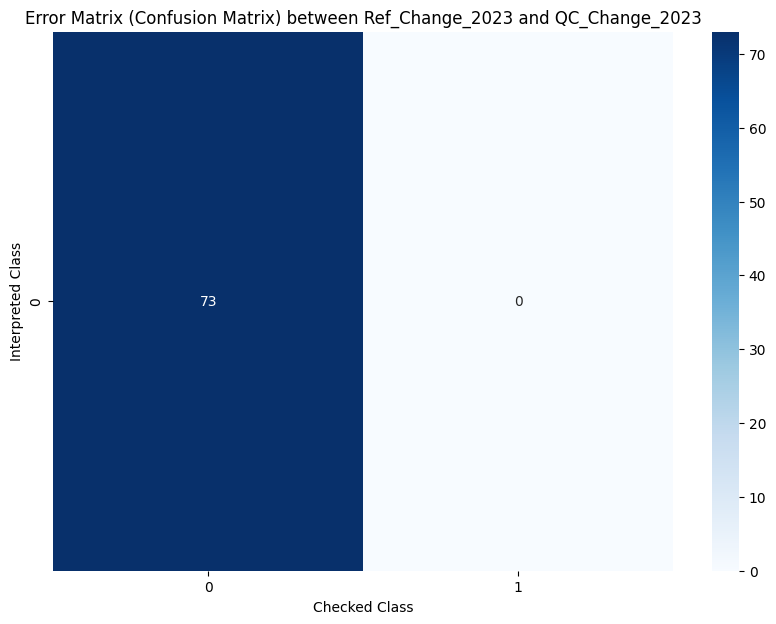

In [105]:
# Assuming merged_ceo_qc is your DataFrame and has the necessary columns
# Example reference and predicted classes
ref_column = 'Ref_Change_2023'  # Reference class column
qc_column = 'QC_Change_2023'     # QC class column

# Step 1: Identify unique classes
ref_classes = sorted(merged_ceo_qc[ref_column].unique())
qc_classes = sorted(merged_ceo_qc[qc_column].unique())

# Step 2: Create the confusion matrix
error_matrix_Change = confusion_matrix(
    merged_ceo_qc[ref_column],
    merged_ceo_qc[qc_column],
    labels=ref_classes  # Ensure all reference classes are included
)

# Step 3: Initialize an empty DataFrame with all combinations of reference and QC classes
error_matrix_Change_df = pd.DataFrame(0, index=ref_classes, columns=qc_classes)

# Step 4: Fill the DataFrame with the confusion matrix values
for i, ref_class in enumerate(ref_classes):
    if i < error_matrix_Change.shape[0]:  # Check bounds
        for j, qc_class in enumerate(qc_classes):
            if j < error_matrix_Change.shape[1]:  # Check bounds
                error_matrix_Change_df.at[ref_class, qc_class] = error_matrix_Change[i, j]

# Step 5: Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(error_matrix_Change_df, annot=True, cmap='Blues', fmt='g', cbar=True)

# Add titles and labels
plt.title('Error Matrix (Confusion Matrix) between Ref_Change_2023 and QC_Change_2023')
plt.ylabel('Interpreted Class')
plt.xlabel('Checked Class')

# Show the plot
plt.show()

In [74]:
# Calculate the sum of diagonal elements (correctly classified observations)
correctly_classified_Change = np.trace(error_matrix_Change_df)

# Calculate the total number of observations
total_observations_Change = error_matrix_Change_df.to_numpy().sum()

# Calculate the percentage agreement
percentage_agreement_Change = (correctly_classified_Change / total_observations_Change) * 100

print(f"General Percentage Agreement: {percentage_agreement_Change:.2f}%")

General Percentage Agreement: 100.00%


In [75]:
print(merged_ceo_qc.columns.tolist())

['plotid_qc_clean', 'sampleid_qc_clean', 'sample_internal_id', 'lon', 'lat', 'sample_geom', 'pl_sampleid', 'pl_plotid_old', 'pl_id', 'QC_FNF_2022', 'QC_Regeneration', 'QC_Change_2023', 'QC_Change_Type_2023', 'QC_ArtFor', 'QC_ArtMine', 'QC_InfraR', 'QC_Urb', 'QC_IndFor', 'QC_Other', 'QC_Other_Desc', 'QC_IndMine', 'QC_IndAg', 'QC_ArtAg', 'QC_NFtype_2022', 'QC_Ftype_2022', 'pl_collection', 'interpreted_qc', 'QC_LCover_2022', 'QC_Change_Year_2023', 'QC_Change_LCover_2023', 'ID', 'plotid_ceo', 'sampleid_ceo', 'lon_ceo', 'lat_ceo', 'TNT_stratum', 'Ref_FNF_2022', 'Ref_Regeneration', 'Ref_Change_2023', 'Ref_Change_Type_2023', 'ArtFor', 'ArtMine', 'InfraR', 'Urb', 'IndFor', 'Other', 'Other_Desc', 'IndMine', 'IndAg', 'ArtAg', 'Ref_NFtype_2022', 'Ref_Ftype_2022', 'collection', 'interpreted', 'Ref_LCover_2022', 'Ref_Change_Year_2023', 'Ref_Change_LCover_2023', 'Def2023', 'Deg2023', 'Defall', 'Degall', 'Stable', 'NF', 'DensFor', 'DensDryFor', 'SecFor', 'DryOpenFor', 'Mangrove', 'Swamp', 'Gallery', 

In [76]:
merged_ceo_qc = merged_ceo_qc.rename(columns={'lon_qc_clean': 'lon'})
merged_ceo_qc = merged_ceo_qc.rename(columns={'lat_qc_clean': 'lat'})

In [77]:
want_columns = ['plotid_qc_clean', 'sampleid_qc_clean', 'sample_internal_id', 'lon', 'lat', 'sample_geom', 'pl_sampleid', 
                'pl_plotid_old', 'pl_id', 'QC_FNF_2022', 'QC_Regeneration', 'QC_Change_2023', 'QC_Change_Type_2023', 'QC_ArtFor', 'QC_ArtMine', 
                'QC_InfraR', 'QC_Urb', 'QC_IndFor', 'QC_Other', 'QC_Other_Desc', 'QC_IndMine', 'QC_IndAg', 'QC_ArtAg', 'QC_NFtype_2022', 'QC_Ftype_2022', 
                'pl_collection', 'interpreted_qc', 'QC_LCover_2022', 'QC_Change_Year_2023', 'QC_Change_LCover_2023', 'ID', 'plotid_ceo', 'sampleid_ceo', 
                'lon_ceo', 'lat_ceo', 'Ref_FNF_2022', 'Ref_Regeneration', 'Ref_Change_2023', 'Ref_Change_Type_2023', 'ArtFor', 'ArtMine', 'InfraR', 
                'Urb', 'IndFor', 'Other', 'Other_Desc', 'IndMine', 'IndAg', 'ArtAg', 'Ref_NFtype_2022', 'Ref_Ftype_2022', 'collection', 'interpreted', 
                'Ref_LCover_2022', 'Ref_Change_Year_2023', 'Ref_Change_LCover_2023']

In [78]:
merged_ceo_qc_select = merged_ceo_qc[want_columns]

##### replace QC data into ceo 

In [79]:
# Step 1: Remove rows with empty 'sample_geom' in ceo_qc
ceo_qc_filtered = ceo_qc_clean[ceo_qc_clean['sample_geom'].notna()]
len(ceo_qc_filtered)

75

In [80]:
# Step 1: Merge the DataFrames on 'sample_geom'
merged_df = ceo.merge(ceo_qc_filtered,
                       on='sample_geom', 
                       how='left', 
                       suffixes=('', '_qc'))

In [81]:
len(merged_df)

753

In [82]:
merged_df['interpreted_qc'].value_counts(dropna=False)

interpreted_qc
NaN    678
1       75
Name: count, dtype: int64

In [83]:
merged_df['QC_Change_Type_2023'].value_counts(dropna=False)

QC_Change_Type_2023
NaN       678
Stable     69
NF          4
Deg         1
Def         1
Name: count, dtype: int64

In [84]:
merged_df['Ref_Change_Type_2023'].value_counts(dropna=False)

Ref_Change_Type_2023
Stable    663
NF         78
Deg         6
Def         6
Name: count, dtype: int64

In [85]:
merged_df['QC_LCover_2022'].value_counts(dropna=False)

QC_LCover_2022
NaN     678
1.0      64
3.0       4
17.0      3
7.0       1
9.0       1
8.0       1
15.0      1
Name: count, dtype: int64

In [86]:
print(merged_df.columns.tolist())

['ID', 'plotid', 'sampleid', 'lon', 'lat', 'TNT_stratum', 'sample_geom', 'Ref_FNF_2022', 'Ref_Regeneration', 'Ref_Change_2023', 'Ref_Change_Type_2023', 'ArtFor', 'ArtMine', 'InfraR', 'Urb', 'IndFor', 'Other', 'Other_Desc', 'IndMine', 'IndAg', 'ArtAg', 'Ref_NFtype_2022', 'Ref_Ftype_2022', 'collection', 'interpreted', 'Ref_LCover_2022', 'Ref_Change_Year_2023', 'Ref_Change_LCover_2023', 'Def2023', 'Deg2023', 'Defall', 'Degall', 'Stable', 'NF', 'DensFor', 'DensDryFor', 'SecFor', 'DryOpenFor', 'Mangrove', 'Swamp', 'Gallery', 'Plantation', 'Woodland', 'Shrubland', 'Grassland', 'Aquatic', 'Bare', 'Cultivated', 'Builtup', 'Water', 'DensFor_Def', 'DensDryFor_Def', 'SecFor_Def', 'DryOpenFor_Def', 'Mangrove_Def', 'Swamp_Def', 'Gallery_Def', 'Plantation_Def', 'Woodland_Def', 'DensFor_Deg', 'DensDryFor_Deg', 'SecFor_Deg', 'DryOpenFor_Deg', 'Mangrove_Deg', 'Swamp_Deg', 'Gallery_Deg', 'Plantation_Deg', 'Woodland_Deg', 'DensFor_Stable', 'DensDryFor_Stable', 'SecFor_Stable', 'DryOpenFor_Stable', 'Mangr

In [87]:
merged_df['interpreted_qc'] = merged_df['interpreted_qc'].fillna(0)
merged_df['interpreted_qc'] = merged_df['interpreted_qc'].astype(str)
merged_df['interpreted_qc'].value_counts(dropna=False)

interpreted_qc
0    678
1     75
Name: count, dtype: int64

In [88]:
merged_df['QC_LCover_2022'] = merged_df['QC_LCover_2022'].astype(float).fillna(0).astype(int).astype(str)
merged_df['QC_LCover_2022'].value_counts(dropna=False)

QC_LCover_2022
0     678
1      64
3       4
17      3
7       1
9       1
8       1
15      1
Name: count, dtype: int64

In [89]:
merged_df['Ref_LCover_2022'].value_counts(dropna=False)

Ref_LCover_2022
1     514
3      92
2      42
16     29
15     22
14     14
9      10
7       7
17      6
18      6
8       6
11      2
12      1
10      1
4       1
Name: count, dtype: int64

In [90]:
# Check the current type of the column
print(merged_df['Ref_LCover_2022'].dtype)

int64


In [91]:
merged_df['Ref_LCover_2022'] = merged_df['Ref_LCover_2022'].astype(str)

In [92]:
# Replace values in 'Ref' with 'QC' where 'interpreted_qc' is 1
merged_df.loc[merged_df['interpreted_qc'] == 1, 'Ref_Ftype_2022'] = merged_df['QC_Ftype_2022']
merged_df.loc[merged_df['interpreted_qc'] == 1, 'Ref_NFtype_2022'] = merged_df['QC_NFtype_2022']
merged_df.loc[merged_df['interpreted_qc'] == 1, 'Ref_Regeneration'] = merged_df['QC_Regeneration']
merged_df.loc[merged_df['interpreted_qc'] == 1, 'Ref_FNF_2022'] = merged_df['QC_FNF_2022']
merged_df.loc[merged_df['interpreted_qc'] == 1, 'Ref_Change_2023'] = merged_df['QC_Change_2023']
merged_df.loc[merged_df['interpreted_qc'] == 1, 'Ref_Change_Type_2023'] = merged_df['QC_Change_Type_2023']
merged_df.loc[merged_df['interpreted_qc'] == 1, 'Ref_LCover_2022'] = merged_df['QC_LCover_2022']
merged_df.loc[merged_df['interpreted_qc'] == 1, 'Ref_Change_Year_2023'] = merged_df['QC_Change_Year_2023']
merged_df.loc[merged_df['interpreted_qc'] == 1, 'Ref_Change_LCover_2023'] = merged_df['QC_Change_LCover_2023']
merged_df.loc[merged_df['interpreted_qc'] == 1, 'ArtFor'] = merged_df['QC_ArtFor']
merged_df.loc[merged_df['interpreted_qc'] == 1, 'ArtMine'] = merged_df['QC_ArtMine']
merged_df.loc[merged_df['interpreted_qc'] == 1, 'InfraR'] = merged_df['QC_InfraR']
merged_df.loc[merged_df['interpreted_qc'] == 1, 'Urb'] = merged_df['QC_Urb']
merged_df.loc[merged_df['interpreted_qc'] == 1, 'IndFor'] = merged_df['QC_IndFor']
merged_df.loc[merged_df['interpreted_qc'] == 1, 'Other'] = merged_df['QC_Other']
merged_df.loc[merged_df['interpreted_qc'] == 1, 'Other_Desc'] = merged_df['QC_Other_Desc']
merged_df.loc[merged_df['interpreted_qc'] == 1, 'IndMine'] = merged_df['QC_IndMine']
merged_df.loc[merged_df['interpreted_qc'] == 1, 'IndAg'] = merged_df['QC_IndAg']
merged_df.loc[merged_df['interpreted_qc'] == 1, 'ArtAg'] = merged_df['QC_ArtAg']

In [93]:
merged_df['Ref_Change_Year_2023'].value_counts(dropna=False)

Ref_Change_Year_2023
Stable     663
NF          78
Deg2023      6
Def2023      6
Name: count, dtype: int64

In [50]:
merged_df['Ref_Change_Type_2023'].value_counts(dropna=False)

Ref_Change_Type_2023
Stable    663
NF         78
Deg         6
Def         6
Name: count, dtype: int64

In [51]:
merged_df.loc[:,'Def2023'] = np.where(merged_df['Ref_Change_Year_2023'] == 'Def2023', 1, 0)
merged_df.loc[:,'Deg2023'] = np.where(merged_df['Ref_Change_Year_2023'] == 'Deg2023', 1, 0)
merged_df['Deg2023'].value_counts(dropna=False)

Deg2023
0    747
1      6
Name: count, dtype: int64

In [52]:
merged_df.loc[:,'Defall'] = np.where(merged_df['Ref_Change_Type_2023'] == 'Def', 1, 0)
merged_df.loc[:,'Degall'] = np.where(merged_df['Ref_Change_Type_2023'] == 'Deg', 1, 0)
merged_df['Defall'].value_counts(dropna=False)

Defall
0    747
1      6
Name: count, dtype: int64

In [53]:
merged_df.loc[:,'Stable'] = np.where(merged_df['Ref_Change_Type_2023'] == 'Stable', 1, 0)
merged_df.loc[:,'NF'] = np.where(merged_df['Ref_Change_Type_2023'] == 'NF', 1, 0)
merged_df['Stable'].value_counts(dropna=False)

Stable
1    663
0     90
Name: count, dtype: int64

In [54]:
merged_df.loc[:,'DensFor'] = np.where(merged_df['Ref_LCover_2022'] == '1', 1, 0).astype(int)
merged_df.loc[:,'DensDryFor'] = np.where(merged_df['Ref_LCover_2022'] == '2', 1, 0).astype(int)
merged_df.loc[:,'SecFor'] = np.where(merged_df['Ref_LCover_2022'] == '3', 1, 0).astype(int)
merged_df.loc[:,'DryOpenFor'] = np.where(merged_df['Ref_LCover_2022'] == '4', 1, 0).astype(int)
merged_df.loc[:,'Mangrove'] = np.where(merged_df['Ref_LCover_2022'] == '7', 1, 0).astype(int)
merged_df.loc[:,'Swamp'] = np.where(merged_df['Ref_LCover_2022'] == '8', 1, 0).astype(int)
merged_df.loc[:,'Gallery'] = np.where(merged_df['Ref_LCover_2022'] == '9', 1, 0).astype(int)
merged_df.loc[:,'Plantation'] = np.where(merged_df['Ref_LCover_2022'] == '10', 1, 0).astype(int)
merged_df.loc[:,'Woodland'] = np.where(merged_df['Ref_LCover_2022'] == '11', 1, 0).astype(int)
merged_df.loc[:,'Shrubland'] = np.where(merged_df['Ref_LCover_2022'] == '12', 1, 0).astype(int)
merged_df.loc[:,'Grassland'] = np.where(merged_df['Ref_LCover_2022'] == '13', 1, 0).astype(int)
merged_df.loc[:,'Aquatic'] = np.where(merged_df['Ref_LCover_2022'] == '14', 1, 0).astype(int)
merged_df.loc[:,'Bare'] = np.where(merged_df['Ref_LCover_2022'] == '15', 1, 0).astype(int)
merged_df.loc[:,'Cultivated'] = np.where(merged_df['Ref_LCover_2022'] == '16', 1, 0).astype(int)
merged_df.loc[:,'Builtup'] = np.where(merged_df['Ref_LCover_2022'] == '17', 1, 0).astype(int)
merged_df.loc[:,'Water'] = np.where(merged_df['Ref_LCover_2022'] == '18', 1, 0).astype(int)
merged_df['Woodland'].value_counts(dropna=False)

Woodland
0    751
1      2
Name: count, dtype: int64

In [55]:
merged_df.loc[:,'DensFor_Def'] = ((merged_df['DensFor'] == 1) & (merged_df['Defall'] == 1)).astype(int)
merged_df.loc[:,'DensDryFor_Def'] = ((merged_df['DensDryFor'] == 1) &  (merged_df['Defall'] == 1)).astype(int)
merged_df.loc[:,'SecFor_Def'] = ((merged_df['SecFor'] == 1) &  (merged_df['Defall'] == 1)).astype(int)
merged_df.loc[:,'DryOpenFor_Def'] = ((merged_df['DryOpenFor'] == 1) &  (merged_df['Defall'] == 1)).astype(int)
merged_df.loc[:,'Mangrove_Def'] = ((merged_df['Mangrove'] == 1) &  (merged_df['Defall'] == 1)).astype(int)
merged_df.loc[:,'Swamp_Def'] = ((merged_df['Swamp'] == 1) &  (merged_df['Defall'] == 1)).astype(int)
merged_df.loc[:,'Gallery_Def'] = ((merged_df['Gallery'] == 1) & (merged_df['Defall'] == 1)).astype(int)
merged_df.loc[:,'Plantation_Def'] = ((merged_df['Plantation'] == 1) &  (merged_df['Defall'] == 1)).astype(int)
merged_df.loc[:,'Woodland_Def'] = ((merged_df['Woodland'] == 1) & (merged_df['Defall'] == 1)).astype(int)
merged_df['Woodland_Def'].value_counts(dropna=False)

Woodland_Def
0    753
Name: count, dtype: int64

In [56]:
merged_df.loc[:,'DensFor_Deg'] = ((merged_df['DensFor'] == 1) & (merged_df['Degall'] == 1)).astype(int)
merged_df.loc[:,'DensDryFor_Deg'] = ((merged_df['DensDryFor'] == 1) &  (merged_df['Degall'] == 1)).astype(int)
merged_df.loc[:,'SecFor_Deg'] = ((merged_df['SecFor'] == 1) & (merged_df['Degall'] == 1)).astype(int)
merged_df.loc[:,'DryOpenFor_Deg'] = ((merged_df['DryOpenFor'] == 1)& (merged_df['Degall'] == 1)).astype(int)
merged_df.loc[:,'Mangrove_Deg'] = ((merged_df['Mangrove'] == 1) & (merged_df['Degall'] == 1)).astype(int)
merged_df.loc[:,'Swamp_Deg'] = ((merged_df['Swamp'] == 1)& (merged_df['Degall'] == 1)).astype(int)
merged_df.loc[:,'Gallery_Deg'] = ((merged_df['Gallery'] == 1) & (merged_df['Degall'] == 1)).astype(int)
merged_df.loc[:,'Plantation_Deg'] = ((merged_df['Plantation'] == 1) & (merged_df['Degall'] == 1)).astype(int)
merged_df.loc[:,'Woodland_Deg'] = ((merged_df['Woodland'] == 1) & (merged_df['Degall'] == 1)).astype(int)
merged_df['Woodland_Deg'].value_counts(dropna=False)

Woodland_Deg
0    753
Name: count, dtype: int64

In [57]:
merged_df.loc[:,'DensFor_Stable'] = ((merged_df['DensFor'] == 1) & (merged_df['Ref_Change_Type_2023'] == "Stable")).astype(int)
merged_df.loc[:,'DensDryFor_Stable'] = ((merged_df['DensDryFor'] == 1) & (merged_df['Ref_Change_Type_2023'] == "Stable")).astype(int)
merged_df.loc[:,'SecFor_Stable'] = ((merged_df['SecFor'] == 1) & (merged_df['Ref_Change_Type_2023'] == "Stable")).astype(int)
merged_df.loc[:,'DryOpenFor_Stable'] = ((merged_df['DryOpenFor'] == 1) & (merged_df['Ref_Change_Type_2023'] == "Stable")).astype(int)
merged_df.loc[:,'Mangrove_Stable'] = ((merged_df['Mangrove'] == 1) & (merged_df['Ref_Change_Type_2023'] == "Stable")).astype(int)
merged_df.loc[:,'Swamp_Stable'] = ((merged_df['Swamp'] == 1) & (merged_df['Ref_Change_Type_2023'] == "Stable")).astype(int)
merged_df.loc[:,'Gallery_Stable'] = ((merged_df['Gallery'] == 1) & (merged_df['Ref_Change_Type_2023'] == "Stable")).astype(int)
merged_df.loc[:,'Plantation_Stable'] = ((merged_df['Plantation'] == 1) & (merged_df['Ref_Change_Type_2023'] == "Stable")).astype(int)
merged_df.loc[:,'Woodland_Stable'] = ((merged_df['Woodland'] == 1) & (merged_df['Ref_Change_Type_2023'] == "Stable")).astype(int)
merged_df['Woodland_Stable'].value_counts(dropna=False)

Woodland_Stable
0    751
1      2
Name: count, dtype: int64

In [58]:
#columns_to_convert = ['Deg2023','Def2023','Degall','Defall','Stable','NF',
#'DensFor','DensDryFor','SecFor','DryOpenFor','Mangrove','Swamp','Gallery','Plantation','Woodland','Shrubland','Grassland','Aquatic','Bare','Cultivated','Builtup','Water',
#'DensFor_Def','DensDryFor_Def','SecFor_Def','DryOpenFor_Def','Mangrove_Def','Swamp_Def','Gallery_Def','Plantation_Def','Woodland_Def',
#'DensFor_Deg','DensDryFor_Deg','SecFor_Deg','DryOpenFor_Deg','Mangrove_Deg','Swamp_Deg','Gallery_Deg','Plantation_Deg','Woodland_Deg',
#'DensFor_stable','DensDryFor_stable','SecFor_stable','DryOpenFor_stable','Mangrove_stable','Swamp_stable','Gallery_stable','Plantation_stable','Woodland_stable']
#merged_df.loc[:,columns_to_convert] = merged_df[columns_to_convert].fillna(0)

In [59]:
# Create a matrix showing the number of matching values between two columns
matrix = pd.crosstab(merged_df['Ref_LCover_2022'], merged_df['Ref_Change_Type_2023'], rownames=['Ref_LCover_2022'], colnames=['Ref_Change_Type_2023'])

# Display the matrix
print(matrix)

Ref_Change_Type_2023  Def  Deg  NF  Stable
Ref_LCover_2022                           
1                       1    1   0     512
10                      0    0   0       1
11                      0    0   0       2
12                      0    0   1       0
14                      0    0  14       0
15                      0    0  22       0
16                      0    0  29       0
17                      0    0   6       0
18                      0    0   6       0
2                       0    0   0      42
3                       5    5   0      82
4                       0    0   0       1
7                       0    0   0       7
8                       0    0   0       6
9                       0    0   0      10


In [60]:
merged_df['Ref_Change_LCover_2023'].value_counts(dropna=False)

Ref_Change_LCover_2023
Stable_1     512
Stable_3      82
Stable_2      42
NF_16         29
NF_15         22
NF_14         14
Stable_9      10
Stable_7       7
NF_17          6
Stable_8       6
NF_18          6
Def_3          5
Deg_3          5
Stable_11      2
NF_12          1
Stable_10      1
Def_1          1
Stable_4       1
Deg_1          1
Name: count, dtype: int64

In [61]:
# Step 3: Select only the original columns from ceo plus the updated columns
updated_ceo = merged_df[ceo.columns.tolist() + ['interpreted_qc']]

In [62]:
updated_ceo['Ref_Change_Type_2023'].value_counts(dropna=False)

Ref_Change_Type_2023
Stable    663
NF         78
Deg         6
Def         6
Name: count, dtype: int64

In [63]:
updated_ceo.head()

,ID,plotid,sampleid,lon,lat,TNT_stratum,sample_geom,Ref_FNF_2022,Ref_Regeneration,Ref_Change_2023,Ref_Change_Type_2023,ArtFor,ArtMine,InfraR,Urb,IndFor,Other,Other_Desc,IndMine,IndAg,ArtAg,Ref_NFtype_2022,Ref_Ftype_2022,collection,interpreted,Ref_LCover_2022,Ref_Change_Year_2023,Ref_Change_LCover_2023,Def2023,Deg2023,Defall,Degall,Stable,NF,DensFor,DensDryFor,SecFor,DryOpenFor,Mangrove,Swamp,Gallery,Plantation,Woodland,Shrubland,Grassland,Aquatic,Bare,Cultivated,Builtup,Water,DensFor_Def,DensDryFor_Def,SecFor_Def,DryOpenFor_Def,Mangrove_Def,Swamp_Def,Gallery_Def,Plantation_Def,Woodland_Def,DensFor_Deg,DensDryFor_Deg,SecFor_Deg,DryOpenFor_Deg,Mangrove_Deg,Swamp_Deg,Gallery_Deg,Plantation_Deg,Woodland_Deg,DensFor_Stable,DensDryFor_Stable,SecFor_Stable,DryOpenFor_Stable,Mangrove_Stable,Swamp_Stable,Gallery_Stable,Plantation_Stable,Woodland_Stable,ISO,interpreted_qc
0,0,0,0,10.329144,1.166597,1,POINT(10.32914355 1.166597144),1,NaN,0,Stable,0,0,0,0,0,0,NaN,0,0,0,NaN,3.0,coll_2023_1,1,3,Stable,Stable_3,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,EQG,0
1,1,1,1,10.235449,1.674684,1,POINT(10.23544926 1.674684268),1,NaN,0,Stable,0,0,0,0,0,0,NaN,0,0,0,NaN,1.0,coll_2023_1,1,1,Stable,Stable_1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,EQG,0
2,2,2,2,8.765895,3.447330,1,POINT(8.76589529 3.447329819),1,NaN,0,Stable,0,0,0,0,0,0,NaN,0,0,0,NaN,1.0,coll_2023_1,1,1,Stable,Stable_1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,EQG,0
3,3,3,3,10.967397,1.110003,1,POINT(10.96739656 1.110003281),1,NaN,0,Stable,0,0,0,0,0,0,NaN,0,0,0,NaN,1.0,coll_2023_1,1,1,Stable,Stable_1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,EQG,0
4,4,4,4,10.259973,1.766492,1,POINT(10.25997327 1.76649209),1,NaN,0,Stable,0,0,0,0,0,0,NaN,0,0,0,NaN,1.0,coll_2023_1,1,1,Stable,Stable_1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,EQG,0


In [64]:
updated_ceo.to_csv(ceo_qc_data_out,index_label='ID')